In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os 

os.chdir("../")

from einops import rearrange
import einops 
import numpy as np
import torch

In [23]:
q = np.random.uniform(size=[32, 8, 128, 10])
k = np.random.uniform(size=[32, 8, 128, 3])

In [27]:
sim2 = np.einsum("bhdi, bhdj -> bhdji", q, k)

In [80]:
from datasets import load_dataset

dataset = load_dataset("mnist")
IMAGE_SIZE = 28
CHANNELS = 1
BATCH_SIZE = 64
TIMESTEPS = 300


Found cached dataset mnist (/home/johannes/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [81]:
from unet import Unet
from diffusion import Diffusion

unet = Unet(
    channels=[32, 64, 128, 256],
    in_channels=1,
    resnet_block_groups=8,
    use_convnext=False,
    convnext_mult=2,
    init_channel_mult=32,
)

diffusion = Diffusion(
    timesteps=TIMESTEPS,
)

functools.partial(<class 'utils.ResnetBlock'>, norm_groups=8)


In [78]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [   
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)

def normalize(examples):
    
    examples["x"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]

    return examples

transformed_dataset = dataset.with_transform(normalize)

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=BATCH_SIZE, shuffle=True)

In [67]:
from typing import List

from torchvision.transforms import Compose, ToTensor, Lambda

reverse_transform = transforms.Compose([
     # transforms.Lambda(lambda t: t[0, :, :, :]),
     transforms.Resize(128),
     transforms.Lambda(lambda t: (t + 1) / 2),
     transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.to("cpu"),),
     transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     transforms.ToPILImage(),
])

reverse_transform2 = transforms.Compose([
     # transforms.Lambda(lambda t: t[0, :, :, :]),
     transforms.Resize(128),
     transforms.Lambda(lambda t: (t + 1) / 2),
     # transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     transforms.Lambda(lambda t: t * 255.),
     transforms.Lambda(lambda t: t.to("cpu"),),
     # transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
     # transforms.ToPILImage(),
])


def _generate_image(
    model: torch.nn.Module,
    diffusion: Diffusion,
    timesteps: int,
    shape: List[int],
    device: str,
):
    with torch.no_grad():

        x = torch.randn(shape, device=device)

        timesteps_iter = list(range(timesteps))
        timesteps_iter.reverse()
        
        Y = [x]
        
        for t in timesteps_iter:

            t = torch.Tensor([t]).long().to(device)

            predicted_noise = model.forward(x, t)

            x = diffusion.backward(x, predicted_noise, t)

            Y.append(x)
            
        return torch.cat(Y, dim=0)

In [50]:
y = _generate_image(
    model=unet,
    diffusion=diffusion,
    timesteps=TIMESTEPS,
    shape=[1, 1, 32, 32],
    device=device,
)

In [51]:
print(y.shape)

torch.Size([201, 1, 32, 32])


In [52]:
image = reverse_transform(y[-1, :, :, :])

image.save("tmp.png")

In [11]:

for step, batch in enumerate(dataloader):

    x = batch["x"].to(device)
    
    break
        

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"

unet.to(device)

Unet(
  (_init_conv): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (_down_sampling_layers): ModuleList(
    (0): ModuleList(
      (0): ConvNextBlock(
        (_time_embedder): Sequential(
          (0): GELU(approximate=none)
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (_dw_conv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=32)
        (_convs): Sequential(
          (0): GroupNorm(1, 32, eps=1e-05, affine=True)
          (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): GELU(approximate=none)
          (3): GroupNorm(1, 64, eps=1e-05, affine=True)
          (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )


In [60]:
x_noised, noise, time = diffusion.forward(x)

In [61]:
noise_predicted = unet.forward(x_noised.to(device), time.to(device))

h torch.Size([1, 128, 7, 7])
torch.Size([1, 256, 7, 7])
before up last torch.Size([1, 64, 7, 7])
ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
hejsans
h torch.Size([1, 64, 14, 14])
torch.Size([1, 128, 14, 14])
before up last torch.Size([1, 32, 14, 14])
ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
hejsans
last22222222 torch.Size([1, 32, 28, 28])


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

writer = SummaryWriter("runs/test2")
writer.add_scalar("hejsan", 5, 9)


device = "cuda" if torch.cuda.is_available() else "cpu"

unet.to(device)

optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

iteration = 0

for e in range(500):

    for step, batch in enumerate(dataloader):

        iteration += 1

        x = batch["x"].to(device)

        x_noised, noise, time = diffusion.forward(x)

        noise_predicted = unet.forward(x_noised.to(device), time.to(device))

        loss = diffusion.loss(noise, noise_predicted)
        
        unet.zero_grad()
        loss.backward()
        optimizer.step()
        
        writer.add_scalar("loss", loss, iteration)
    
    print(e)
    
    y = _generate_image(
        model=unet,
        diffusion=diffusion,
        timesteps=TIMESTEPS,
        shape=[1, 1, 32, 32],
        device=device,
    )
        
    writer.add_image(f'images',np.expand_dims(np.asarray(reverse_transform(y[-1, :, :, :])), 2), e, dataformats='HWC')

0
1
2
3
4
5


In [ ]:
loss

In [17]:
y = unet(batch["x"], time=None)

In [24]:
img = reverse_transform(y[0, :, :, :])

In [ ]:
from PIL import Image
from matplotlib import cm


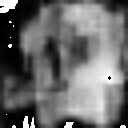